# IMPORT LIBRARIES

In [47]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras.layers import Cropping1D,Embedding, Flatten, Dense, concatenate, Dropout,GlobalAveragePooling1D,GlobalMaxPooling1D,LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Importing the Dataset

## Read and Explore the Data

In [48]:
#Import the data set
df = pd.read_csv('Reviews3.csv')

In [49]:
df.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5


In [50]:
# Dropping the columns
df = df.drop(['Id','HelpfulnessNumerator','HelpfulnessDenominator'], axis = 1) 


In [51]:
# see few rows of the imported dataset
df.tail()

,ProductId,UserId,Score
568449,B001EO7N10,A28KG5XORO54AY,5
568450,B003S1WTCU,A3I8AFVPEE8KI5,2
568451,B004I613EE,A121AA1GQV751Z,5
568452,B004I613EE,A3IBEVCTXKNOH,5
568453,B001LR2CU2,A3LGQPJCZVL9UC,5


In [52]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  568454
No of columns:  3


In [53]:
#Check Data types
df.dtypes

ProductId    object
UserId       object
Score         int64
dtype: object

In [54]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 ProductId    0
UserId       0
Score        0
dtype: int64


### There are no missing values with total records 568454


In [55]:
# Summary statistics of 'rating' variable
df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568454.0,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0


In [56]:
# find minimum and maximum ratings 

def find_min_max_rating():
    print('The minimum rating is: %d' %(df['Score'].min()))
    print('The maximum rating is: %d' %(df['Score'].max()))
    
find_min_max_rating() 

The minimum rating is: 1
The maximum rating is: 5


### Ratings are on scale of 1 - 5


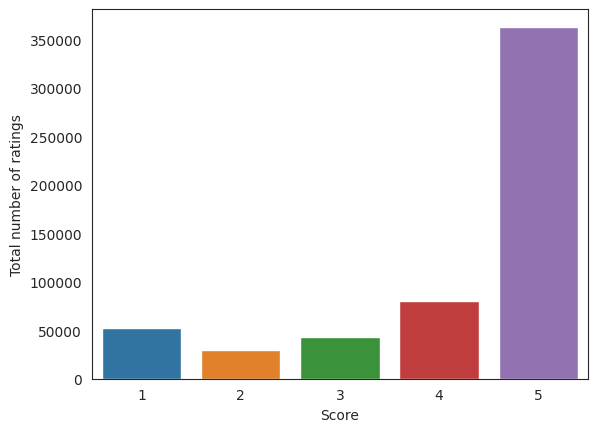

In [57]:
# Check the distribution of ratings
with sns.axes_style('white'):
    g = sns.countplot(data=df, x="Score")
    g.set_ylabel("Total number of ratings")


In [58]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['UserId'].nunique())
print('Number of unique ITEMS in Raw data = ', df['ProductId'].nunique())

Number of unique USERS in Raw data =  256059
Number of unique ITEMS in Raw data =  74258


### Take subset of dataset to make it less sparse/more dense. ( For example, keep the users only who has given 50 or more number of ratings )

In [59]:
# Top 10 users based on rating
most_rated = df.groupby('UserId').size().sort_values(ascending=False)[:5]
most_rated

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
dtype: int64

### Data model preparation as per requirement on number of minimum ratings


In [60]:
counts = df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 40].index)]

In [61]:
counts

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A2O8OFVSTO9PF3      1
A1C6KXG47GAQ7B      1
A1TU5DS89D9OVD      1
A3N005JS5FG5FI      1
A3LGQPJCZVL9UC      1
Name: count, Length: 256059, dtype: int64

In [62]:
df_final.head()

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
18,B001GVISJM,A2A9X58G2GTBLP,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5


In [63]:
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['UserId'].nunique())
print('Number of unique ITEMS in final data = ', df_final['ProductId'].nunique())

Number of users who have rated 50 or more items = 30130
Number of unique USERS in final data =  430
Number of unique ITEMS in final data =  13227


-------------------

### Split the data randomly into train and test dataset.

In [64]:
# Split the data into training and test sets
train_data, test_data = train_test_split(df_final, test_size=0.1, random_state=0)

In [65]:
# Create a dictionary mapping user IDs to unique indices
user_ids = df_final['UserId'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user_id = {index: user_id for index, user_id in enumerate(user_ids)}

# Create a dictionary mapping product IDs to unique indices
product_ids = df_final['ProductId'].unique()
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}
index_to_product_id = {index: product_id for index, product_id in enumerate(product_ids)}

# Convert user and product IDs to indices and food names in the dataframe
train_data['user_index'] = train_data['UserId'].map(user_id_to_index)
train_data['product_index'] = train_data['ProductId'].map(product_id_to_index)

test_data['user_index'] = test_data['UserId'].map(user_id_to_index)
test_data['product_index'] = test_data['ProductId'].map(product_id_to_index)

In [66]:
len(df_final['UserId'].unique())

430

## DATA

In [67]:
# Prepare the training data
x_train_user = train_data['user_index'].values
x_train_product = train_data['product_index'].values
x_train = np.concatenate((x_train_user.reshape(-1, 1), x_train_product.reshape(-1, 1)), axis=1)
y_train = train_data['Score'].values

scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1))

# Prepare the test data
x_test_user = test_data['user_index'].values
x_test_product = test_data['product_index'].values
x_test = np.concatenate((x_test_user.reshape(-1, 1), x_test_product.reshape(-1, 1)), axis=1)
y_test = test_data['Score'].values

In [23]:
# Set the input shape
num_users = len(user_ids)
num_products = len(product_ids)
embedding_dim = 512

# Create the embedding layer
embedding_layer = Embedding(num_users + num_products +1, embedding_dim, input_length=2)

# Create the model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128))
#model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(32, activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [24]:
# Load tensorboard 
%load_ext tensorboard

In [25]:
import tensorflow as tf
import datetime, os

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 13832), started 3 days, 3:24:41 ago. (Use '!kill 13832' to kill it.)

In [26]:
# Setup for tensorboard
from datetime import datetime
import os
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1,callbacks=[tensorboard_callback])

Epoch 1/5
763/763 [==============================] - 47s 52ms/step - loss: 0.0650 - accuracy: 0.5967 - val_loss: 0.0631 - val_accuracy: 0.5892
Epoch 2/5
763/763 [==============================] - 38s 50ms/step - loss: 0.0464 - accuracy: 0.6091 - val_loss: 0.0641 - val_accuracy: 0.5881
Epoch 3/5
763/763 [==============================] - 39s 50ms/step - loss: 0.0327 - accuracy: 0.6216 - val_loss: 0.0640 - val_accuracy: 0.5841
Epoch 4/5
763/763 [==============================] - 39s 51ms/step - loss: 0.0264 - accuracy: 0.6271 - val_loss: 0.0655 - val_accuracy: 0.5852
Epoch 5/5
763/763 [==============================] - 38s 50ms/step - loss: 0.0225 - accuracy: 0.6303 - val_loss: 0.0684 - val_accuracy: 0.5796


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.3)

In [68]:
# Create a dictionary mapping user IDs to unique indices
user_ids = df_final['UserId'].unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user_id = {index: user_id for index, user_id in enumerate(user_ids)}

# Create a dictionary mapping product IDs to unique indices
product_ids = df_final['ProductId'].unique()
product_id_to_index = {product_id: index for index, product_id in enumerate(product_ids)}
index_to_product_id = {index: product_id for index, product_id in enumerate(product_ids)}

# Convert user and product IDs to indices and food names in the dataframe
df_final['user_index'] = df_final['UserId'].map(user_id_to_index)
df_final['product_index'] = df_final['ProductId'].map(product_id_to_index)

C:\Users\widih\AppData\Local\Temp\ipykernel_25908\3467069078.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['user_index'] = df_final['UserId'].map(user_id_to_index)
C:\Users\widih\AppData\Local\Temp\ipykernel_25908\3467069078.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['product_index'] = df_final['ProductId'].map(product_id_to_index)


In [69]:
user_ids

array(['A2MUGFV2TDQ47K', 'A2A9X58G2GTBLP', 'A2G7B7FKP2O2PU',
       'AQLL2R1PPR46X', 'AY12DBB0U420B', 'A2YIO225BTKVPU',
       'A1Z54EM24Y40LL', 'A3NID9D9WMIV01', 'A1IU7S4HCK1XK0',
       'A3POAWC2JPQQQP', 'A19SDJ2TSSL8HI', 'A3OXRFCJI67IMN',
       'AF72GTWZGAC61', 'A2582KMXLK2P06', 'A1YLOZQKBX3J1S',
       'AVQIRN6E7J7UA', 'A3OXHLG6DIBRW8', 'A2TJG4N8LNJW23',
       'A25C2M3QF9G7OQ', 'ALSAOZ1V546VT', 'A1T61QP7QHYBRQ',
       'AMRMK86X3PKXD', 'A2NO1TXXS9T0EE', 'A1IRN1M05TPOVT',
       'A2OEUROGZDTXUJ', 'A22PUBSSNP54L', 'A2BLJGGWN8GTXQ',
       'AYB4ELCS5AM8P', 'A3PZ4AXTY9J1DZ', 'A2ZEFDVX4X5TPX',
       'A3RMGIKUWGPZOK', 'A3PJZ8TU8FDQ1K', 'A31N6KB160O508',
       'A1B05INWIDZ74O', 'A30H2335OM7RD6', 'A38KP1POQ191WT',
       'A3MFU0GVZUVH3K', 'ACYR6O588USK', 'AY1EF0GOH80EK', 'AWLK6NSSV0YNA',
       'A2A1XYSB692L6J', 'A2TN9C5E4A0I3F', 'AR7TAEEUDHMUB',
       'ADS5APY1NKTL4', 'AG7EF0SVBQOUX', 'A1Q7A78VSQ5GQ4',
       'A2A8KWCE8RKB9T', 'A2II09GQGWOMTQ', 'AQQLWCMRNDFGI',
       'A24ZV048V7J0MT

In [31]:
uidx= df_final['user_index'].values.astype(np.int64)
pidx = df_final['product_index'].values.astype(np.int64)

In [32]:
uidx

array([  0,   1,   2, ...,  39,  72, 196], dtype=int64)

In [33]:
# Create a new DataFrame with converted data arrays
df_converted = pd.DataFrame({'UsecrId': uidx, 'ProductId': pidx, 'Score': 0})

# Create pivot table with the converted DataFrame
final_ratings_matrix = pd.pivot_table(df_converted, index='UserId', columns='ProductId', values='Score')
final_ratings_matrix.fillna(0, inplace=True)

array3 = final_ratings_matrix.reset_index().melt(id_vars=['UserId'], value_vars=final_ratings_matrix.columns)
#array3.columns = ['UserId', 'ProductId', 'Score']
array3 = array3[['UserId', 'ProductId']].values.astype(np.int64)

In [ ]:
# Predict the ratings for the test set
ratings = model.predict(array3)

# Inverse transform the scaled ratings to get the actual ratings
predicted_ratings = scaler.inverse_transform(ratings)

predicted_ratings

In [ ]:
array3.shape

In [ ]:
df_predicted = pd.DataFrame(array3, columns=['UserId', 'ProductId'])
df_predicted['PredictedRatings']=predicted_ratings
df_predicted

In [ ]:
# Rename the columns back to 'UserId' and 'ProductId'
df_predicted = df_predicted.rename(columns={'UserId': 'user_index', 'ProductId': 'product_index'})

# Convert the user index back to 'UserId'
df_predicted['user_index'] = df_predicted['user_index'].map(index_to_user_id)
# Convert the user index back to 'UserId'
df_predicted['product_index'] = df_predicted['product_index'].map(index_to_product_id)

df_predicted = df_predicted.rename(columns={'user_index': 'UserId',
                                           'product_index':'ProductId'})

In [ ]:
df_predicted

In [ ]:
# Specify the user ID for which you want to find related product IDs
user_id = 'A2A9X58G2GTBLP'

# Filter the DataFrame for the specified user ID
user_data = df_predicted[df_predicted['UserId'] == user_id]

# Get the unique product IDs for the user
product_ids = user_data['ProductId']
scorepredict = user_data['PredictedRatings']

print("Product IDs related to User ID", user_id)
sorting_data = user_data.sort_values(by='PredictedRatings',ascending=False)
sorting_data

### Sort the DataFrame by the 'score' column in descending order
sorted_df = df_final.sort_values(by='score', ascending=False)

print(sorted_df)


In [ ]:
df_predicted.to_csv('ratingpredict_resulted.csv', index=False)

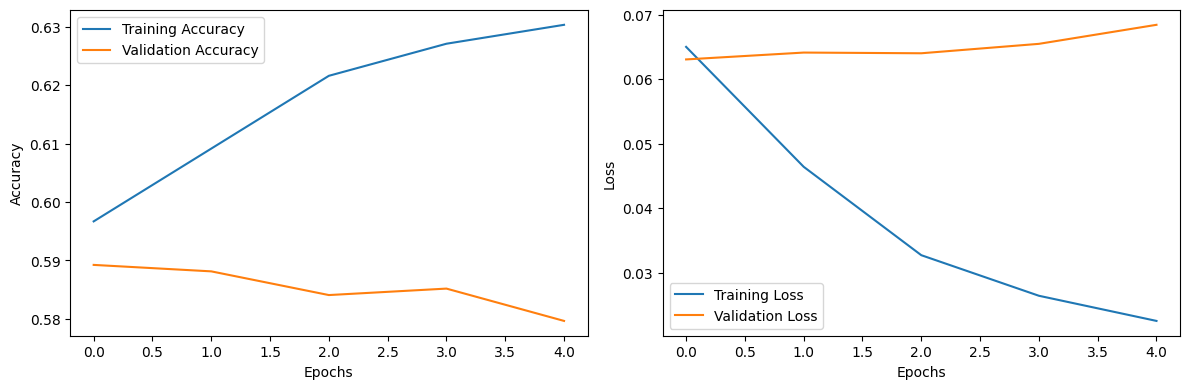

In [35]:
# Plot the model accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Convert model to TF LITE or H5

In [ ]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

In [ ]:
#POST TRAIN QUANTIZATION
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

In [ ]:
import pathlib
tflite_model_file = pathlib.Path(export_dir+'/recommender_model_64up.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
model.save(export_dir+'/recommender_model.h5')

In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path=export_dir+'/recommender_model_64up.tflite')
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

# try to load model then run

In [79]:
!pip install pipreqs

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13793 sha256=b1de3b5f1adde27f3c67ad82b07bcd9502d70d051cfb907fb29ec97853a9d815
  Stored in directory: c:\users\widih\appdata\local\pip\cache\wheels\fc\ab\d4\5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [81]:
import subprocess

# Run pip freeze command to get installed packages
pip_freeze = subprocess.check_output(['pip', 'freeze']).decode('utf-8')

# Write the requirements to a requirements.txt file
with open('requirements.txt', 'w') as file:
    file.write(pip_freeze)